In [43]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import Counter
from matplotlib import pyplot

In [2]:
city = 'Bhopal'
month = 'July'
PATH = f'./../../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

/tmp/ipykernel_224586/70406848.py:2: DtypeWarning: Columns (5,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH+f'{month}.csv')


In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(156415, 29)
(156415, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(156415, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(156186, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [7]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

Delivery_Time           0.039062
Location_Code           0.000000
Order_Date              0.000000
Order_Number            0.000000
Driver_Shift            0.000000
Kitchen_Display_Time    0.000000
Oven_Time               0.000000
Menu_Code               0.000000
Item Description        0.000000
Quantity                0.000000
prep_time               0.000000
dtype: float64

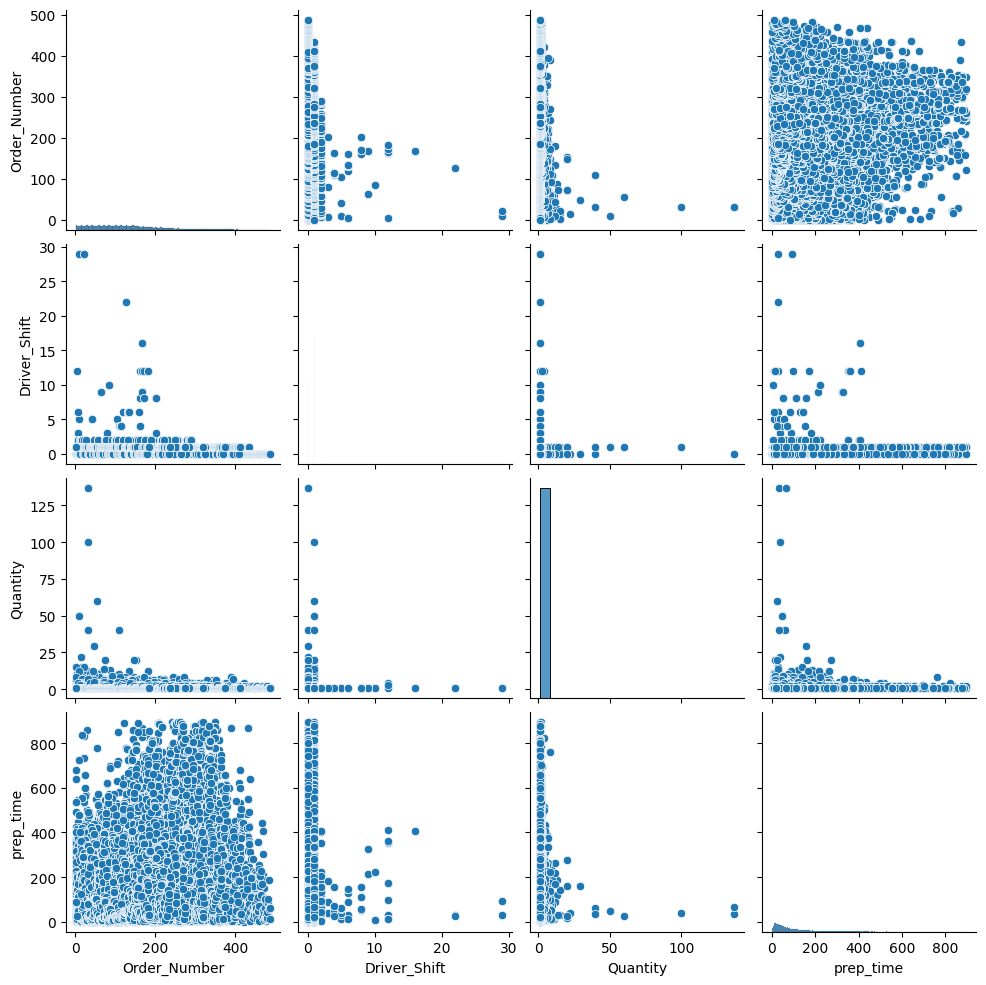

In [8]:
sns.pairplot(data=df)

<Axes: >

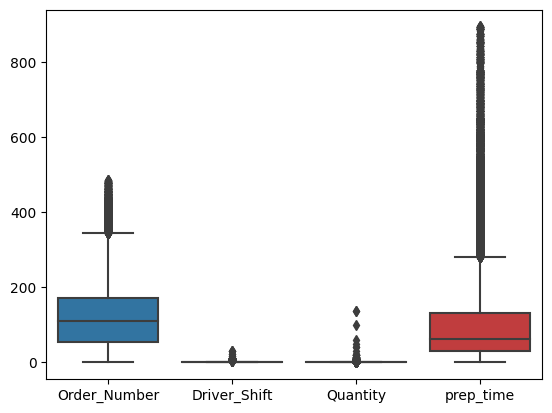

In [9]:
sns.boxplot(df)

In [10]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = sorted(Counter(df['Location_Code'].values.tolist()), reverse=True)
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

146
12


In [11]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [12]:
def get_preparation_time(item):
    return item['prep_time']

In [13]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [14]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [15]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [16]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[3]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [18]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [19]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [20]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [21]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [22]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/tmp/ipykernel_224586/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_224586/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_224586/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_224586/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_224586/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_224586/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [23]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [24]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1

    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [25]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [26]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [27]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [28]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [29]:
lengthQueue(sampleItem)

2

In [30]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'xgboost'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [31]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [32]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [33]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                0 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                0 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [34]:
def updateFeatures(storeId, Xnp, fc=feature_cols):
    restWiseDFs[storeId][fc] = Xnp

In [35]:
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
#         features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
#         features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10509, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12344, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16460, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(18798, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12105, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14284, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(17184, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10763, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12230, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9330, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10736, 9)
(11443, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [40]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 3):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

/tmp/ipykernel_224586/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")


In [37]:
save_object(restWiseDFs, 'WithoutNormalization.pkl')

In [38]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols[4:]]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols[3:]]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            restWiseDFs[storeId][feature_cols[3:]] = X_scalednp
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [39]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [41]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
        
    firstTimeTrain = datetime(2022, 7, 1)
    lastTimeTrain = datetime(2022, 7, 21) + timedelta(days=1)
    
    firstTimeVal = datetime(2022, 7, 22)
    lastTimeVal = datetime(2022, 7, 31) + timedelta(days=1)
    
    firstTimeTest = datetime(2022, 7, 22)
    lastTimeTest = datetime(2022, 7, 31) + timedelta(days=1)

    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()
    print("TRAIN TEST SPLITED")


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['hist'],
        'n_estimators': [100, 150],
        'learning_rate': [0.08],
        'subsample': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_depth': [5, 6, 7],
    }
    
    {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9, 'tree_method': 'hist'}

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)
    
    print("FITTING TO GRID SEARCH START")
    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)
    

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train, y_train)
    
    print("MODEL PREPARED")
    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_train_val, y_train_val)
    print("Test score:", test_score)

    overallPredictions = best_regressor.predict(overallDF.loc[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    print("ACCURACY ON Train DATA : ")
    print("RMSE score: ", getRMSE(trainingData.prep_time.values.tolist(), best_regressor.predict(trainingData.loc[:, feature_cols])))
        
#     print("ACCURACY ON Validation DATA : ")
#     print("RMSE score: ", getRMSE(validationData.prep_time.values.tolist(), best_regressor.predict(validationData.loc[:, feature_cols])))

    print("ACCURACY ON Test DATA : ")
    print("RMSE score: ", getRMSE(testData.prep_time.values.tolist(), best_regressor.predict(testData.loc[:, feature_cols])))
    

    

TRAIN TEST SPLITED
FITTING TO GRID SEARCH START
Best hyperparameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7, 'tree_method': 'hist'}
Best mean cross-validated score: 0.22569132724558152
MODEL PREPARED
Test score: 0.3110359403568477
ACCURACY ON Train DATA : 
RMSE score:  75.56758062004386
ACCURACY ON Test DATA : 
RMSE score:  94.67948255564373


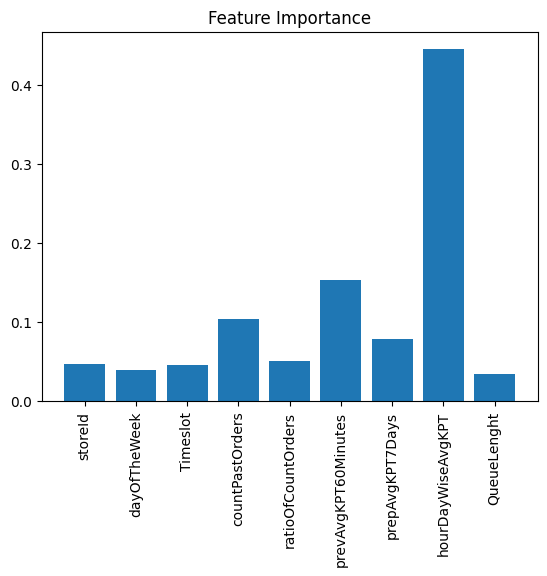

0.9999999143183231


In [45]:
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [44]:
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        timeslots = df2.feature_3.unique()
        for ts in sorted(timeslots):
            df3 = df2.loc[df2['feature_3'] == ts]
            l1 = df3.prep_time.values.tolist()
            l2 = df3.predicted_prep_time_central.values.tolist()
            l3 = df3.hour_wise_avg_kpt_of_the_day.values.tolist()
            rmseModel = getRMSE(l1, l2)
            rmseBaseline = getRMSE(l1, l3)
#             print(f"{day} \t {ts} \t {rmseModel} \t {rmseBaseline}")
            diffs.append(rmseModel-rmseBaseline)
# print(sorted(diffs))
diffs = sorted(diffs)
print(f"lowest: {diffs[0]}, highest: {diffs[len(diffs)-1]}, median: {diffs[len(diffs)//2]}")


lowest: -98.97661119395855, highest: 30.77781390427164, median: -1.4064971270967206


In [88]:
def getMAE(actual, predictions):
    mse = sklearn.metrics.mean_absolute_error(actual, predictions)
    return mse

def getSTD(actual, predictions):
    a = []
    for i in range(0, len(actual)):
        a.append(abs(actual[i]-predictions[i]))
    return np.std(a)

def getDayOfTheWeek(a):
    if a==1:
        return "Monday"
    if a==2:
        return "Tuesday"
    if a==3:
        return "Wednesday"
    if a==4:
        return "Thursday"
    if a==5:
        return "Friday"
    if a==6:
        return "Saturday"
    if a==7:
        return "Sunday"

In [107]:
dfError = pd.DataFrame()
allDays = overallDF.Order_Date.unique()
diffs = []
diffsRMSE = []
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        for ts in sorted(timeslots):
            df3 = df2.loc[df['feature_3'] == ts]
            if(df3.size == 0):
                continue
            rmseModel = getRMSE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            rmseBaseline = getRMSE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            maeModel = getMAE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            maeBaseline = getMAE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())
            
            stdModel = getSTD(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            stdBaseline = getSTD(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()+1
            a = {"storeId":[storeId], \
                 "date":[day], \
                 "timeslot":ts, \
                 "weekday": [getDayOfTheWeek(weekday)], \
                 "total_orders":[df3.size], \
                 "mean_kpt":[np.mean(df3.prep_time.values.tolist())], \
                 "std_kpt":[np.std(df3.prep_time.values.tolist())], \
                 "model rmse": [rmseModel], \
                 "baseline rmse": [rmseBaseline], \
                 "model mae": [maeModel], \
                 "baseline mae": [maeBaseline], \
                 "model std AE": [stdModel], \
                 "baseline std AE": [stdBaseline]
                }
            diffs.append(maeModel-maeBaseline)
            diffsRMSE.append(rmseModel-rmseBaseline)
            print(a)
            b = pd.DataFrame(a)
            dfError = pd.concat([dfError, b], ignore_index= True)
        
        

{'storeId': ['DPI67072'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [50], 'mean_kpt': [59.9795], 'std_kpt': [0.8835000000000015], 'model rmse': [5.164115297715929], 'baseline rmse': [17.31493384320469], 'model mae': [4.730251129150393], 'baseline mae': [13.09508854315349], 'model std AE': [2.071910003662108], 'baseline std AE': [11.328088543153488]}
{'storeId': ['DPI67072'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [124.52316666666668], 'std_kpt': [113.77908687220258], 'model rmse': [121.11340933289813], 'baseline rmse': [118.15991543621394], 'model mae': [78.81414546373156], 'baseline mae': [78.94216926776444], 'model std AE': [91.96079814279506], 'baseline std AE': [87.91984717453084]}
{'storeId': ['DPI67072'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [625], 'mean_kpt': [110.05215999999999], 'std_kpt': [74.31825471776366]

{'storeId': ['DPI67072'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [600], 'mean_kpt': [74.72854166666667], 'std_kpt': [51.66076749412069], 'model rmse': [53.59956452734555], 'baseline rmse': [57.58221131328351], 'model mae': [40.804227390925085], 'baseline mae': [44.169732580469365], 'model std AE': [34.755263551737855], 'baseline std AE': [36.94246585567154]}
{'storeId': ['DPI67072'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [400], 'mean_kpt': [56.57006249999999], 'std_kpt': [64.19317252000864], 'model rmse': [65.69829483608568], 'baseline rmse': [67.71198752305764], 'model mae': [41.99090139389038], 'baseline mae': [41.146272343628596], 'model std AE': [50.527518685344305], 'baseline std AE': [53.77636587337098]}
{'storeId': ['DPI67072'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [625], 'mean_kpt': [66.56044], 'std_kpt': [37.770238763428

{'storeId': ['DPI67072'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [150], 'mean_kpt': [71.8975], 'std_kpt': [43.28435803593872], 'model rmse': [50.55314169341589], 'baseline rmse': [52.736209971727455], 'model mae': [48.42020311991374], 'baseline mae': [50.34646901624945], 'model std AE': [14.529420666388582], 'baseline std AE': [15.695250866996702]}
{'storeId': ['DPI67072'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [700], 'mean_kpt': [33.84975], 'std_kpt': [24.546147194948365], 'model rmse': [28.063834099068217], 'baseline rmse': [31.127718214684077], 'model mae': [25.949462104797362], 'baseline mae': [29.35181423384069], 'model std AE': [10.68663655280321], 'baseline std AE': [10.36367900095723]}
{'storeId': ['DPI67072'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [600], 'mean_kpt': [21.993], 'std_kpt': [13.917265443206386], 'model rmse': [3

{'storeId': ['DPI67072'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 22.0, 'weekday': ['Thursday'], 'total_orders': [400], 'mean_kpt': [35.8151875], 'std_kpt': [19.57428098046883], 'model rmse': [33.17590237563336], 'baseline rmse': [27.330142745460826], 'model mae': [29.733939332962038], 'baseline mae': [23.756637754773607], 'model std AE': [14.71507221121557], 'baseline std AE': [13.511434604649882]}
{'storeId': ['DPI67072'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 23.0, 'weekday': ['Thursday'], 'total_orders': [50], 'mean_kpt': [23.6], 'std_kpt': [7.923], 'model rmse': [39.68559985879189], 'baseline rmse': [17.378205778471056], 'model mae': [39.43701210021973], 'baseline mae': [15.549048007246379], 'model std AE': [4.434964797973631], 'baseline std AE': [7.7607436594202905]}
{'storeId': ['DPI67072'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [125], 'mean_kpt': [245.90659999999997], 'std_kpt': [97.49176138238555], 'model rmse': [

{'storeId': ['DPI67072'], 'date': ['2022-07-19 00:00:00'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [900], 'mean_kpt': [44.94925], 'std_kpt': [38.68637087196284], 'model rmse': [39.29658279825407], 'baseline rmse': [39.72981727352369], 'model mae': [28.32503779262966], 'baseline mae': [28.228606604416022], 'model std AE': [27.23809196082096], 'baseline std AE': [27.95718422446549]}
{'storeId': ['DPI67072'], 'date': ['2022-07-19 00:00:00'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [850], 'mean_kpt': [59.479147058823536], 'std_kpt': [53.36839745807512], 'model rmse': [54.222651223123655], 'baseline rmse': [53.77179245541149], 'model mae': [37.561680866017056], 'baseline mae': [37.46906080662159], 'model std AE': [39.105191933859636], 'baseline std AE': [38.567799342684076]}
{'storeId': ['DPI67072'], 'date': ['2022-07-19 00:00:00'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [1325], 'mean_kpt': [59.816584905660385], 'std_kpt': [54.890843675

{'storeId': ['DPI67072'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [450], 'mean_kpt': [121.16072222222222], 'std_kpt': [28.966214882947025], 'model rmse': [52.378291297141175], 'baseline rmse': [37.07133617457241], 'model mae': [51.5309993862576], 'baseline mae': [36.22955843155099], 'model std AE': [9.383043294245969], 'baseline std AE': [7.855129637567598]}
{'storeId': ['DPI67072'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [400], 'mean_kpt': [89.1851875], 'std_kpt': [25.627849503076604], 'model rmse': [51.22726527932634], 'baseline rmse': [56.24686434845788], 'model mae': [44.75030560302734], 'baseline mae': [49.89130179739999], 'model std AE': [24.932766722410356], 'baseline std AE': [25.97244220312321]}
{'storeId': ['DPI67072'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [600], 'mean_kpt': [106.36245833333334], 'std_kpt': [34.9912547943282

{'storeId': ['DPI67072'], 'date': ['2022-07-28 00:00:00'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [325], 'mean_kpt': [100.587], 'std_kpt': [42.830091359301974], 'model rmse': [68.59565854075358], 'baseline rmse': [73.01219496529039], 'model mae': [58.30805053945687], 'baseline mae': [62.76861606294512], 'model std AE': [36.132196347963706], 'baseline std AE': [37.29452307232477]}
{'storeId': ['DPI67072'], 'date': ['2022-07-28 00:00:00'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [900], 'mean_kpt': [116.91536111111115], 'std_kpt': [80.15416467073962], 'model rmse': [85.23090195189023], 'baseline rmse': [81.18263082252987], 'model mae': [76.76805724419488], 'baseline mae': [72.83216911589496], 'model std AE': [37.02663952460099], 'baseline std AE': [35.86216236008162]}
{'storeId': ['DPI67072'], 'date': ['2022-07-28 00:00:00'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1275], 'mean_kpt': [86.49429411764707], 'std_kpt': [61.79383650154

{'storeId': ['DPI66653'], 'date': ['2022-07-02 00:00:00'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [375], 'mean_kpt': [38.369533333333344], 'std_kpt': [23.192609980671765], 'model rmse': [30.759260322604188], 'baseline rmse': [32.047293820346496], 'model mae': [28.06043719685872], 'baseline mae': [27.51808307325881], 'model std AE': [12.599363472607639], 'baseline std AE': [16.42510715888472]}
{'storeId': ['DPI66653'], 'date': ['2022-07-02 00:00:00'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [200], 'mean_kpt': [53.852000000000004], 'std_kpt': [19.77656409743614], 'model rmse': [22.48764480557081], 'baseline rmse': [24.16788360110772], 'model mae': [18.154938983917237], 'baseline mae': [19.302993611316854], 'model std AE': [13.269979630419861], 'baseline std AE': [14.542387541189806]}
{'storeId': ['DPI66653'], 'date': ['2022-07-02 00:00:00'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [425], 'mean_kpt': [49.218999999999994], 'std_kpt'

{'storeId': ['DPI66653'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 13.0, 'weekday': ['Thursday'], 'total_orders': [875], 'mean_kpt': [44.040371428571426], 'std_kpt': [35.746536521207766], 'model rmse': [47.728647037716826], 'baseline rmse': [39.281938122125325], 'model mae': [43.78478719569614], 'baseline mae': [31.52824659354897], 'model std AE': [18.997793510788494], 'baseline std AE': [23.43160961963241]}
{'storeId': ['DPI66653'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 14.0, 'weekday': ['Thursday'], 'total_orders': [800], 'mean_kpt': [68.49853125], 'std_kpt': [35.76499994231824], 'model rmse': [36.1502742758832], 'baseline rmse': [39.054939557178386], 'model mae': [30.704577219009398], 'baseline mae': [32.27437315894137], 'model std AE': [19.080651666635276], 'baseline std AE': [21.992115428313426]}
{'storeId': ['DPI66653'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [1150], 'mean_kpt': [66.81756521739132], 'std_kpt': [54.73

{'storeId': ['DPI66653'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 22.0, 'weekday': ['Monday'], 'total_orders': [450], 'mean_kpt': [98.09394444444445], 'std_kpt': [84.40247729412806], 'model rmse': [80.22207696039965], 'baseline rmse': [85.94946918524577], 'model mae': [60.604992991129556], 'baseline mae': [70.13188793989904], 'model std AE': [52.560597945470725], 'baseline std AE': [49.68731777034211]}
{'storeId': ['DPI66653'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 23.0, 'weekday': ['Monday'], 'total_orders': [225], 'mean_kpt': [71.95377777777779], 'std_kpt': [69.27775458700495], 'model rmse': [74.4245855356798], 'baseline rmse': [78.7159079015017], 'model mae': [67.32744991048177], 'baseline mae': [74.77164717024182], 'model std AE': [31.71802989955849], 'baseline std AE': [24.6047746627878]}
{'storeId': ['DPI66653'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 24.0, 'weekday': ['Monday'], 'total_orders': [75], 'mean_kpt': [78.50333333333333], 'std_kpt': [13.5056884887648

{'storeId': ['DPI66653'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [2250], 'mean_kpt': [49.6451], 'std_kpt': [38.9281392100453], 'model rmse': [77.05787249410334], 'baseline rmse': [97.85809860353932], 'model mae': [72.34255761379667], 'baseline mae': [92.59510889588738], 'model std AE': [26.541855082341147], 'baseline std AE': [31.659963216320733]}
{'storeId': ['DPI66653'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 22.0, 'weekday': ['Saturday'], 'total_orders': [800], 'mean_kpt': [71.09090624999999], 'std_kpt': [88.14917362394817], 'model rmse': [103.65402831651323], 'baseline rmse': [123.00232220806481], 'model mae': [95.53514408302307], 'baseline mae': [118.76833764237531], 'model std AE': [40.21434857456413], 'baseline std AE': [31.994581451291516]}
{'storeId': ['DPI66653'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 23.0, 'weekday': ['Saturday'], 'total_orders': [875], 'mean_kpt': [130.78194285714287], 'std_kpt': [81.40421807

{'storeId': ['DPI66653'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [475], 'mean_kpt': [50.677315789473674], 'std_kpt': [23.721590268100606], 'model rmse': [37.118148135633156], 'baseline rmse': [43.82266037356806], 'model mae': [33.694186478464225], 'baseline mae': [38.31922151217787], 'model std AE': [15.571085979252883], 'baseline std AE': [21.261769091910892]}
{'storeId': ['DPI66653'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [700], 'mean_kpt': [111.35139285714286], 'std_kpt': [132.40667445529303], 'model rmse': [136.07865527548313], 'baseline rmse': [135.5408993505256], 'model mae': [63.17853781454904], 'baseline mae': [63.47706792046808], 'model std AE': [120.52332878409628], 'baseline std AE': [119.75807799463713]}
{'storeId': ['DPI66653'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1125], 'mean_kpt': [118.08359999999999], 'std_kp

{'storeId': ['DPI66653'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [300], 'mean_kpt': [58.19341666666667], 'std_kpt': [33.14930212553082], 'model rmse': [33.396153920490825], 'baseline rmse': [33.53382449591463], 'model mae': [29.629041709899905], 'baseline mae': [30.08439349941168], 'model std AE': [15.408536076932371], 'baseline std AE': [14.813731909797756]}
{'storeId': ['DPI66653'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [400], 'mean_kpt': [64.855375], 'std_kpt': [57.69724015374891], 'model rmse': [57.45308570064649], 'baseline rmse': [58.42130398863848], 'model mae': [37.81854122161865], 'baseline mae': [37.947731474039394], 'model std AE': [43.25060689047682], 'baseline std AE': [44.41867215155251]}
{'storeId': ['DPI66653'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [425], 'mean_kpt': [57.662705882352945], 'std_kpt': [43.6566355144

{'storeId': ['DPI66653'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [475], 'mean_kpt': [80.17468421052631], 'std_kpt': [33.52209549261601], 'model rmse': [41.37849644260594], 'baseline rmse': [42.519056733031505], 'model mae': [39.24281743099815], 'baseline mae': [40.14342606542554], 'model std AE': [13.121785241654463], 'baseline std AE': [14.01340533904824]}
{'storeId': ['DPI66653'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [525], 'mean_kpt': [21.650571428571432], 'std_kpt': [13.173014806870931], 'model rmse': [28.203144508718502], 'baseline rmse': [23.972937954509284], 'model mae': [24.81051140049526], 'baseline mae': [20.9831334294543], 'model std AE': [13.411035911724102], 'baseline std AE': [11.593526885830263]}
{'storeId': ['DPI66653'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [575], 'mean_kpt': [58.45486956521739], 'std_kpt': [29.3366

{'storeId': ['DPI66576'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [1150], 'mean_kpt': [89.78369565217392], 'std_kpt': [46.96992231476648], 'model rmse': [50.81736459079175], 'baseline rmse': [51.31278407024705], 'model mae': [42.138537123970366], 'baseline mae': [39.29809564599818], 'model std AE': [28.40331376803113], 'baseline std AE': [32.994870626171235]}
{'storeId': ['DPI66576'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [875], 'mean_kpt': [51.82308571428572], 'std_kpt': [26.934291702343668], 'model rmse': [32.43067416396801], 'baseline rmse': [31.114991913462735], 'model mae': [26.18998121948242], 'baseline mae': [24.767110216254363], 'model std AE': [19.126774700733527], 'baseline std AE': [18.83435619581301]}
{'storeId': ['DPI66576'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [525], 'mean_kpt': [49.35471428571429], 'std_kpt': [29.7

{'storeId': ['DPI66576'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 24.0, 'weekday': ['Sunday'], 'total_orders': [375], 'mean_kpt': [77.60806666666667], 'std_kpt': [48.100536741934825], 'model rmse': [70.46743282780565], 'baseline rmse': [92.74943162214853], 'model mae': [63.46412744140625], 'baseline mae': [82.33211782583429], 'model std AE': [30.62619169015711], 'baseline std AE': [42.70690155635911]}
{'storeId': ['DPI66576'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 12.0, 'weekday': ['Monday'], 'total_orders': [275], 'mean_kpt': [162.33754545454545], 'std_kpt': [74.60944596955736], 'model rmse': [86.84020763584698], 'baseline rmse': [76.2280689804999], 'model mae': [55.26382137784091], 'baseline mae': [48.57476444895619], 'model std AE': [66.9860560785236], 'baseline std AE': [58.74700638521313]}
{'storeId': ['DPI66576'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 13.0, 'weekday': ['Monday'], 'total_orders': [275], 'mean_kpt': [99.1627272727273], 'std_kpt': [61.335865714324

{'storeId': ['DPI66576'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [1400], 'mean_kpt': [204.00173214285718], 'std_kpt': [83.69966192658535], 'model rmse': [102.55751422793357], 'baseline rmse': [103.0711592216515], 'model mae': [81.2672570375715], 'baseline mae': [79.12353459740689], 'model std AE': [62.55938505294054], 'baseline std AE': [66.05399409655705]}
{'storeId': ['DPI66576'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [1075], 'mean_kpt': [91.30823255813954], 'std_kpt': [52.11757279809298], 'model rmse': [52.5095906350376], 'baseline rmse': [57.0274293126054], 'model mae': [42.466356409826936], 'baseline mae': [49.04768448966225], 'model std AE': [30.884715992425413], 'baseline std AE': [29.0938539937003]}
{'storeId': ['DPI66576'], 'date': ['2022-07-16 00:00:00'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [975], 'mean_kpt': [65.16176923076924], 'std_kpt': [37.282

{'storeId': ['DPI66576'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [750], 'mean_kpt': [125.19666666666667], 'std_kpt': [74.43824761162027], 'model rmse': [80.1380187893805], 'baseline rmse': [79.39017676983484], 'model mae': [71.04866558024088], 'baseline mae': [69.17498298506169], 'model std AE': [37.07005765782131], 'baseline std AE': [38.956666907758525]}
{'storeId': ['DPI66576'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [550], 'mean_kpt': [93.14772727272727], 'std_kpt': [58.26707739537265], 'model rmse': [61.36666202206156], 'baseline rmse': [69.20403886245037], 'model mae': [51.87052535455878], 'baseline mae': [61.987517177636114], 'model std AE': [32.79200828208007], 'baseline std AE': [30.769249406311665]}
{'storeId': ['DPI66576'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [850], 'mean_kpt': [116.5079705882353], 'std_kpt': [79.95

{'storeId': ['DPI66576'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [1575], 'mean_kpt': [91.07463492063489], 'std_kpt': [74.46905456083203], 'model rmse': [77.95626020858994], 'baseline rmse': [81.60029372814847], 'model mae': [67.88010579233321], 'baseline mae': [72.80044459795302], 'model std AE': [38.333663317390275], 'baseline std AE': [36.86059146107779]}
{'storeId': ['DPI66576'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 22.0, 'weekday': ['Tuesday'], 'total_orders': [1075], 'mean_kpt': [101.05927906976744], 'std_kpt': [48.07215120770105], 'model rmse': [48.235566084881164], 'baseline rmse': [50.39037259547404], 'model mae': [38.861261481706485], 'baseline mae': [40.86495493059875], 'model std AE': [28.57397752465299], 'baseline std AE': [29.48296302665038]}
{'storeId': ['DPI66576'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 23.0, 'weekday': ['Tuesday'], 'total_orders': [1225], 'mean_kpt': [112.65485714285715], 'std_kpt': [61.

{'storeId': ['DPI66449'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [725], 'mean_kpt': [81.85444827586205], 'std_kpt': [19.51244344370731], 'model rmse': [24.462132647648218], 'baseline rmse': [26.99807162034945], 'model mae': [16.027950893007475], 'baseline mae': [11.098428955432302], 'model std AE': [18.479738197346784], 'baseline std AE': [24.611394636199314]}
{'storeId': ['DPI66449'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [800], 'mean_kpt': [39.78521875], 'std_kpt': [24.774687187397515], 'model rmse': [27.158699510739574], 'baseline rmse': [37.239720988008585], 'model mae': [17.46844106864929], 'baseline mae': [20.483224718190804], 'model std AE': [20.795396744130002], 'baseline std AE': [31.10039106520727]}
{'storeId': ['DPI66449'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [62.57085714285713], 'std_kpt': [37.6915115

{'storeId': ['DPI66449'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [375], 'mean_kpt': [85.7844], 'std_kpt': [79.06570517386157], 'model rmse': [78.420877048008], 'baseline rmse': [98.77900882619045], 'model mae': [65.74200567220052], 'baseline mae': [83.96603969098828], 'model std AE': [42.75304254874898], 'baseline std AE': [52.02880705240118]}
{'storeId': ['DPI66449'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [475], 'mean_kpt': [86.96205263157894], 'std_kpt': [35.076631878568364], 'model rmse': [40.78024728027402], 'baseline rmse': [50.775633675582], 'model mae': [35.68514066354852], 'baseline mae': [38.57893617293562], 'model std AE': [19.738270037241158], 'baseline std AE': [33.01258334213571]}
{'storeId': ['DPI66449'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1200], 'mean_kpt': [211.3719583333333], 'std_kpt': [179.34218863947842], '

{'storeId': ['DPI66449'], 'date': ['2022-07-09 00:00:00'], 'timeslot': 24.0, 'weekday': ['Saturday'], 'total_orders': [850], 'mean_kpt': [402.95394117647055], 'std_kpt': [147.2662155166105], 'model rmse': [125.21259433504568], 'baseline rmse': [154.48868955136282], 'model mae': [102.57715784409466], 'baseline mae': [125.559778327934], 'model std AE': [71.80613113613907], 'baseline std AE': [90.00831775751311]}
{'storeId': ['DPI66449'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [150], 'mean_kpt': [53.95766666666666], 'std_kpt': [58.04598625419524], 'model rmse': [59.87351052854876], 'baseline rmse': [62.45809634580239], 'model mae': [50.263536554972326], 'baseline mae': [56.981510958847814], 'model std AE': [32.533277670705104], 'baseline std AE': [25.575793398998226]}
{'storeId': ['DPI66449'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [850], 'mean_kpt': [104.5880882352941], 'std_kpt': [96.96

{'storeId': ['DPI66449'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [1300], 'mean_kpt': [122.38628846153847], 'std_kpt': [100.27333946179631], 'model rmse': [97.16491999650717], 'baseline rmse': [101.48466764379543], 'model mae': [67.66036301128682], 'baseline mae': [72.322769508424], 'model std AE': [69.73590864904915], 'baseline std AE': [71.19378327777639]}
{'storeId': ['DPI66449'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [900], 'mean_kpt': [69.75011111111111], 'std_kpt': [44.22273160489711], 'model rmse': [41.58429753595044], 'baseline rmse': [44.674195513779004], 'model mae': [35.793896469963926], 'baseline mae': [37.9788465013301], 'model std AE': [21.167209949730218], 'baseline std AE': [23.52426328775799]}
{'storeId': ['DPI66449'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1025], 'mean_kpt': [71.7710487804878], 'std_kpt': [67.7226644

{'storeId': ['DPI66449'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 21.0, 'weekday': ['Wednesday'], 'total_orders': [2100], 'mean_kpt': [153.00192857142858], 'std_kpt': [83.81284367818257], 'model rmse': [82.21952618597643], 'baseline rmse': [99.70626810574949], 'model mae': [70.055090570359], 'baseline mae': [84.98036064473136], 'model std AE': [43.03875894383182], 'baseline std AE': [52.15053407460932]}
{'storeId': ['DPI66449'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 22.0, 'weekday': ['Wednesday'], 'total_orders': [1850], 'mean_kpt': [308.4888243243243], 'std_kpt': [134.1245175377694], 'model rmse': [167.05188180439794], 'baseline rmse': [179.3063453872896], 'model mae': [141.7218531098237], 'baseline mae': [150.2704348373109], 'model std AE': [88.437817507603], 'baseline std AE': [97.82413766525876]}
{'storeId': ['DPI66449'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 23.0, 'weekday': ['Wednesday'], 'total_orders': [775], 'mean_kpt': [152.435], 'std_kpt': [72.260012521538

{'storeId': ['DPI66449'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [375], 'mean_kpt': [70.23553333333332], 'std_kpt': [33.17815747318642], 'model rmse': [35.83108605481437], 'baseline rmse': [63.068119462917565], 'model mae': [28.575559318033854], 'baseline mae': [53.53183144856643], 'model std AE': [21.617218542843155], 'baseline std AE': [33.34562511561471]}
{'storeId': ['DPI66449'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [1000], 'mean_kpt': [124.2328], 'std_kpt': [51.71554583063008], 'model rmse': [46.90455231125857], 'baseline rmse': [52.87080376529073], 'model mae': [41.213025537109374], 'baseline mae': [42.83324710457464], 'model std AE': [22.39472155658923], 'baseline std AE': [30.994109654357374]}
{'storeId': ['DPI66449'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [1050], 'mean_kpt': [48.67659523809524], 'std_kpt': [31.2105828580

{'storeId': ['DPI66449'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 19.0, 'weekday': ['Sunday'], 'total_orders': [1550], 'mean_kpt': [98.83183870967741], 'std_kpt': [78.4306037357936], 'model rmse': [121.56407105756729], 'baseline rmse': [126.33432643922599], 'model mae': [110.21162586138327], 'baseline mae': [119.32729368311736], 'model std AE': [51.29542764301459], 'baseline std AE': [41.48926390183338]}
{'storeId': ['DPI66449'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 20.0, 'weekday': ['Sunday'], 'total_orders': [1975], 'mean_kpt': [142.86268354430376], 'std_kpt': [82.76048911035949], 'model rmse': [78.37786626551419], 'baseline rmse': [98.94270843388388], 'model mae': [65.61937328174446], 'baseline mae': [82.4560717704235], 'model std AE': [42.86242842450609], 'baseline std AE': [54.68688856045222]}
{'storeId': ['DPI66449'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 21.0, 'weekday': ['Sunday'], 'total_orders': [3225], 'mean_kpt': [196.99717054263567], 'std_kpt': [94.9861

{'storeId': ['DPI66373'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 14.0, 'weekday': ['Wednesday'], 'total_orders': [600], 'mean_kpt': [134.53933333333333], 'std_kpt': [95.11304408205825], 'model rmse': [75.60641019372994], 'baseline rmse': [103.7782891295026], 'model mae': [64.25746038564047], 'baseline mae': [88.36249114305905], 'model std AE': [39.84103471510746], 'baseline std AE': [54.42429102560226]}
{'storeId': ['DPI66373'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 15.0, 'weekday': ['Wednesday'], 'total_orders': [600], 'mean_kpt': [68.5085], 'std_kpt': [36.307916940845466], 'model rmse': [38.03446547994195], 'baseline rmse': [40.31912304200823], 'model mae': [33.000615512847894], 'baseline mae': [35.26814118785641], 'model std AE': [18.90978424303351], 'baseline std AE': [19.539444721639985]}
{'storeId': ['DPI66373'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 16.0, 'weekday': ['Wednesday'], 'total_orders': [625], 'mean_kpt': [66.01552000000001], 'std_kpt': [27.92418272

{'storeId': ['DPI66373'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 22.0, 'weekday': ['Monday'], 'total_orders': [1325], 'mean_kpt': [86.83403773584905], 'std_kpt': [34.26174693084538], 'model rmse': [49.9181941690908], 'baseline rmse': [50.18278592919017], 'model mae': [42.206961751685945], 'baseline mae': [39.61532946155596], 'model std AE': [26.65330164904097], 'baseline std AE': [30.80483201167153]}
{'storeId': ['DPI66373'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 23.0, 'weekday': ['Monday'], 'total_orders': [500], 'mean_kpt': [142.22275], 'std_kpt': [111.60842690669688], 'model rmse': [112.1413744753861], 'baseline rmse': [118.06460339494775], 'model mae': [94.79255892944336], 'baseline mae': [105.78495447663651], 'model std AE': [59.91709806755319], 'baseline std AE': [52.428942209263056]}
{'storeId': ['DPI66373'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 24.0, 'weekday': ['Monday'], 'total_orders': [100], 'mean_kpt': [91.28925000000001], 'std_kpt': [20.54900099001165

{'storeId': ['DPI66373'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [850], 'mean_kpt': [46.091529411764704], 'std_kpt': [19.694851620836904], 'model rmse': [42.00428195454877], 'baseline rmse': [48.80457273419865], 'model mae': [39.03619369865867], 'baseline mae': [45.455139261566195], 'model std AE': [15.509199980593234], 'baseline std AE': [17.76841676906835]}
{'storeId': ['DPI66373'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 16.0, 'weekday': ['Sunday'], 'total_orders': [950], 'mean_kpt': [48.727868421052634], 'std_kpt': [30.263204400524906], 'model rmse': [53.068935972230264], 'baseline rmse': [50.65216612680045], 'model mae': [47.75098892051295], 'baseline mae': [43.85048014279796], 'model std AE': [23.155021536110144], 'baseline std AE': [25.3530535554018]}
{'storeId': ['DPI66373'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 17.0, 'weekday': ['Sunday'], 'total_orders': [550], 'mean_kpt': [50.16104545454546], 'std_kpt': [20.1000

{'storeId': ['DPI66373'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [775], 'mean_kpt': [75.05522580645162], 'std_kpt': [59.190278570653746], 'model rmse': [55.82146817082949], 'baseline rmse': [59.63293645388674], 'model mae': [37.03039533652029], 'baseline mae': [39.18500625406399], 'model std AE': [41.77063717455057], 'baseline std AE': [44.95133362851719]}
{'storeId': ['DPI66373'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [775], 'mean_kpt': [58.378709677419344], 'std_kpt': [28.59125025777658], 'model rmse': [34.283095740036984], 'baseline rmse': [35.20541324923342], 'model mae': [28.86449263148154], 'baseline mae': [31.50300159264938], 'model std AE': [18.497884166782157], 'baseline std AE': [15.715661382927259]}
{'storeId': ['DPI66373'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 16.0, 'weekday': ['Sunday'], 'total_orders': [675], 'mean_kpt': [74.72822222222223], 'std_kpt': [35.420757

{'storeId': ['DPI66373'], 'date': ['2022-07-29 00:00:00'], 'timeslot': 24.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [215.6728], 'std_kpt': [150.865660133312], 'model rmse': [172.1173094394312], 'baseline rmse': [161.05444310622403], 'model mae': [122.35871478881836], 'baseline mae': [117.59022697828573], 'model std AE': [121.04839166175452], 'baseline std AE': [110.05031650772841]}
{'storeId': ['DPI66373'], 'date': ['2022-07-30 00:00:00'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [75], 'mean_kpt': [24.355666666666668], 'std_kpt': [13.561191843721636], 'model rmse': [64.22843427492325], 'baseline rmse': [82.30397665682364], 'model mae': [63.13476607259114], 'baseline mae': [80.8524885885886], 'model std AE': [11.802249038523517], 'baseline std AE': [15.388946115933974]}
{'storeId': ['DPI66373'], 'date': ['2022-07-30 00:00:00'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [100], 'mean_kpt': [25.895749999999996], 'std_kpt': [6.7285754946

{'storeId': ['DPI66313'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 12.0, 'weekday': ['Monday'], 'total_orders': [300], 'mean_kpt': [62.12008333333333], 'std_kpt': [37.68459373638502], 'model rmse': [39.44190586761583], 'baseline rmse': [40.258786818381594], 'model mae': [29.120750343322754], 'baseline mae': [30.364558179110276], 'model std AE': [26.601613445649036], 'baseline std AE': [26.43413555755744]}
{'storeId': ['DPI66313'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 13.0, 'weekday': ['Monday'], 'total_orders': [450], 'mean_kpt': [40.12466666666666], 'std_kpt': [16.22394538260585], 'model rmse': [15.488358621257797], 'baseline rmse': [17.833569687944305], 'model mae': [14.638455291748048], 'baseline mae': [15.768560984970613], 'model std AE': [5.060126426502044], 'baseline std AE': [8.329987531685056]}
{'storeId': ['DPI66313'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 14.0, 'weekday': ['Monday'], 'total_orders': [675], 'mean_kpt': [44.25807407407407], 'std_kpt': [22.681

{'storeId': ['DPI66313'], 'date': ['2022-07-09 00:00:00'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [350], 'mean_kpt': [48.64292857142858], 'std_kpt': [26.482413831674048], 'model rmse': [27.854293249055125], 'baseline rmse': [29.043162336839572], 'model mae': [23.327239981515067], 'baseline mae': [22.656549796065004], 'model std AE': [15.221745210361487], 'baseline std AE': [18.171021706619676]}
{'storeId': ['DPI66313'], 'date': ['2022-07-09 00:00:00'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [425], 'mean_kpt': [29.422058823529408], 'std_kpt': [12.34541505018141], 'model rmse': [42.54901678848803], 'baseline rmse': [68.42390081854694], 'model mae': [39.99505835140453], 'baseline mae': [64.84023026634888], 'model std AE': [14.519439973180225], 'baseline std AE': [21.853483526275696]}
{'storeId': ['DPI66313'], 'date': ['2022-07-09 00:00:00'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [725], 'mean_kpt': [43.1043448275862], 'std_kpt': 

{'storeId': ['DPI66313'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [600], 'mean_kpt': [45.947541666666666], 'std_kpt': [26.61217995107248], 'model rmse': [27.75209948498042], 'baseline rmse': [27.329703081220146], 'model mae': [20.673328943888347], 'baseline mae': [19.795071534824633], 'model std AE': [18.514656253952943], 'baseline std AE': [18.843243177299108]}
{'storeId': ['DPI66313'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [200], 'mean_kpt': [46.4705], 'std_kpt': [18.22095057893523], 'model rmse': [19.319528533759282], 'baseline rmse': [18.52710788623626], 'model mae': [14.218238056182864], 'baseline mae': [13.179804694278083], 'model std AE': [13.079980479513434], 'baseline std AE': [13.02100129978195]}
{'storeId': ['DPI66313'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [200], 'mean_kpt': [76.05837500000001], 'std_kpt': [41.15631

{'storeId': ['DPI66313'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 13.0, 'weekday': ['Wednesday'], 'total_orders': [175], 'mean_kpt': [43.021], 'std_kpt': [18.701552395456375], 'model rmse': [18.99970733159019], 'baseline rmse': [19.8803303042241], 'model mae': [14.785105351039343], 'baseline mae': [13.693441301007002], 'model std AE': [11.93270876392908], 'baseline std AE': [14.412397383535007]}
{'storeId': ['DPI66313'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 14.0, 'weekday': ['Wednesday'], 'total_orders': [125], 'mean_kpt': [38.0452], 'std_kpt': [19.044951030653767], 'model rmse': [24.296170452382036], 'baseline rmse': [22.706058141320025], 'model mae': [23.030496997070312], 'baseline mae': [21.105412704927893], 'model std AE': [7.739515922791115], 'baseline std AE': [8.374164487975728]}
{'storeId': ['DPI66313'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 15.0, 'weekday': ['Wednesday'], 'total_orders': [425], 'mean_kpt': [39.4795294117647], 'std_kpt': [21.585782249155542]

{'storeId': ['DPI66313'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [700], 'mean_kpt': [20.17196428571429], 'std_kpt': [8.43913764840487], 'model rmse': [17.41917951386713], 'baseline rmse': [13.83313238153193], 'model mae': [16.036853463309154], 'baseline mae': [12.062710194503039], 'model std AE': [6.800525415927632], 'baseline std AE': [6.771009839633946]}
{'storeId': ['DPI66313'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [275], 'mean_kpt': [39.99700000000001], 'std_kpt': [27.768172205537105], 'model rmse': [27.441943032512846], 'baseline rmse': [28.12897933092148], 'model mae': [24.63347236772017], 'baseline mae': [24.449969043790247], 'model std AE': [12.093480744121894], 'baseline std AE': [13.908216706576967]}
{'storeId': ['DPI66313'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [950], 'mean_kpt': [33.866368421052634], 'std_kpt': [13.1

{'storeId': ['DPI66313'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 23.0, 'weekday': ['Sunday'], 'total_orders': [1325], 'mean_kpt': [41.15332075471698], 'std_kpt': [24.70037653121727], 'model rmse': [28.254236967309996], 'baseline rmse': [27.82052326039024], 'model mae': [24.493069498889856], 'baseline mae': [24.469433703654452], 'model std AE': [14.085150092471803], 'baseline std AE': [13.237383756028741]}
{'storeId': ['DPI66313'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 24.0, 'weekday': ['Sunday'], 'total_orders': [475], 'mean_kpt': [37.61494736842105], 'std_kpt': [28.435855345105345], 'model rmse': [37.60487064971888], 'baseline rmse': [33.95196301480072], 'model mae': [35.94399569220291], 'baseline mae': [30.188515858189188], 'model std AE': [11.052396584496359], 'baseline std AE': [15.536708236890318]}
{'storeId': ['DPI66221'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [75], 'mean_kpt': [116.58433333333335], 'std_kpt': [81.3

{'storeId': ['DPI66221'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 23.0, 'weekday': ['Tuesday'], 'total_orders': [450], 'mean_kpt': [61.68766666666667], 'std_kpt': [35.633589347380905], 'model rmse': [42.09542361412692], 'baseline rmse': [49.8149876038113], 'model mae': [34.43391830444336], 'baseline mae': [36.01031046867529], 'model std AE': [24.21425116446336], 'baseline std AE': [34.42078630591533]}
{'storeId': ['DPI66221'], 'date': ['2022-07-05 00:00:00'], 'timeslot': 24.0, 'weekday': ['Tuesday'], 'total_orders': [225], 'mean_kpt': [90.20455555555557], 'std_kpt': [68.57804633831621], 'model rmse': [70.96669596662855], 'baseline rmse': [78.55718452085436], 'model mae': [67.51522670491538], 'baseline mae': [70.43160657218971], 'model std AE': [21.862435806738816], 'baseline std AE': [34.793965504148034]}
{'storeId': ['DPI66221'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [75], 'mean_kpt': [491.57733333333334], 'std_kpt': [0.26693

{'storeId': ['DPI66221'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 23.0, 'weekday': ['Monday'], 'total_orders': [650], 'mean_kpt': [118.56153846153846], 'std_kpt': [71.61275350008478], 'model rmse': [80.31922933316973], 'baseline rmse': [82.05654380610395], 'model mae': [72.66331486159105], 'baseline mae': [70.38726873966834], 'model std AE': [34.223110232700854], 'baseline std AE': [42.17711204874943]}
{'storeId': ['DPI66221'], 'date': ['2022-07-11 00:00:00'], 'timeslot': 24.0, 'weekday': ['Monday'], 'total_orders': [700], 'mean_kpt': [113.59117857142857], 'std_kpt': [67.73480662219893], 'model rmse': [72.04667017847939], 'baseline rmse': [72.45634750733068], 'model mae': [69.10267899867466], 'baseline mae': [69.18799787893207], 'model std AE': [20.384858081740937], 'baseline std AE': [21.51611590431591]}
{'storeId': ['DPI66221'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [75.3232], 'std_kpt': [4.2223388495003595]

{'storeId': ['DPI66221'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 16.0, 'weekday': ['Sunday'], 'total_orders': [1200], 'mean_kpt': [44.59908333333333], 'std_kpt': [41.730751067025565], 'model rmse': [77.10133809627108], 'baseline rmse': [101.7020563099063], 'model mae': [71.19480364608765], 'baseline mae': [95.15229751289212], 'model std AE': [29.595882653344315], 'baseline std AE': [35.90749971358933]}
{'storeId': ['DPI66221'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 17.0, 'weekday': ['Sunday'], 'total_orders': [1325], 'mean_kpt': [75.08437735849057], 'std_kpt': [56.813982678073124], 'model rmse': [63.41345218816629], 'baseline rmse': [62.938880730455374], 'model mae': [55.46719872125588], 'baseline mae': [54.78891679279178], 'model std AE': [30.735253121416783], 'baseline std AE': [30.975430655198746]}
{'storeId': ['DPI66221'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 18.0, 'weekday': ['Sunday'], 'total_orders': [1900], 'mean_kpt': [100.32882894736842], 'std_kpt': [55.1

{'storeId': ['DPI66221'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [3175], 'mean_kpt': [113.39972440944882], 'std_kpt': [89.98960923313271], 'model rmse': [106.61506368385454], 'baseline rmse': [97.60990128947644], 'model mae': [84.3364852405458], 'baseline mae': [70.98896115855425], 'model std AE': [65.22368482065053], 'baseline std AE': [66.99447905141594]}
{'storeId': ['DPI66221'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1400], 'mean_kpt': [202.79582142857143], 'std_kpt': [117.40528545447468], 'model rmse': [125.43347549760031], 'baseline rmse': [146.5459543910147], 'model mae': [107.29968771362304], 'baseline mae': [116.2344443736901], 'model std AE': [64.96409617601147], 'baseline std AE': [89.24836519238266]}
{'storeId': ['DPI66221'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [1025], 'mean_kpt': [77.60997560975609], 'std_kpt': [38.195

{'storeId': ['DPI66221'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 15.0, 'weekday': ['Wednesday'], 'total_orders': [500], 'mean_kpt': [100.15735], 'std_kpt': [96.73357929916322], 'model rmse': [104.92539773468059], 'baseline rmse': [107.52563353110735], 'model mae': [66.39684609985352], 'baseline mae': [61.59795693028708], 'model std AE': [81.24529474236205], 'baseline std AE': [88.13315816581462]}
{'storeId': ['DPI66221'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 16.0, 'weekday': ['Wednesday'], 'total_orders': [750], 'mean_kpt': [32.52233333333333], 'std_kpt': [35.95769258478945], 'model rmse': [40.05872537849039], 'baseline rmse': [37.83708742962055], 'model mae': [34.90000338745118], 'baseline mae': [30.582560991982046], 'model std AE': [19.664466494293873], 'baseline std AE': [22.278962011917155]}
{'storeId': ['DPI66221'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 17.0, 'weekday': ['Wednesday'], 'total_orders': [775], 'mean_kpt': [52.8818064516129], 'std_kpt': [45.359244

{'storeId': ['DPI66154'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [625], 'mean_kpt': [62.62735999999999], 'std_kpt': [29.08867035789708], 'model rmse': [28.81919354550286], 'baseline rmse': [31.582067226355818], 'model mae': [24.286271725463866], 'baseline mae': [22.884290169913466], 'model std AE': [15.515248057639555], 'baseline std AE': [21.765482620637204]}
{'storeId': ['DPI66154'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [75.75525806451613], 'std_kpt': [25.946845855881723], 'model rmse': [25.458496811617994], 'baseline rmse': [26.84127358932875], 'model mae': [19.027775655438827], 'baseline mae': [21.03723386196294], 'model std AE': [16.913864535151433], 'baseline std AE': [16.669995780871602]}
{'storeId': ['DPI66154'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [525], 'mean_kpt': [62.59042857142857], 'std_kpt': [20.1

{'storeId': ['DPI66154'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1175], 'mean_kpt': [68.35317021276595], 'std_kpt': [42.86231814667982], 'model rmse': [43.76479373406861], 'baseline rmse': [44.969697752026775], 'model mae': [36.826461367992636], 'baseline mae': [36.37270808565841], 'model std AE': [23.646752709353482], 'baseline std AE': [26.444277687698733]}
{'storeId': ['DPI66154'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 22.0, 'weekday': ['Thursday'], 'total_orders': [775], 'mean_kpt': [64.2011935483871], 'std_kpt': [48.08931520948679], 'model rmse': [51.13340297570456], 'baseline rmse': [51.58796317722685], 'model mae': [45.205534595120334], 'baseline mae': [41.9026761015031], 'model std AE': [23.89737520827697], 'baseline std AE': [30.091255877869806]}
{'storeId': ['DPI66154'], 'date': ['2022-07-07 00:00:00'], 'timeslot': 23.0, 'weekday': ['Thursday'], 'total_orders': [525], 'mean_kpt': [94.24952380952381], 'std_kpt': [46.

{'storeId': ['DPI66154'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 13.0, 'weekday': ['Thursday'], 'total_orders': [375], 'mean_kpt': [29.8388], 'std_kpt': [15.238436823594036], 'model rmse': [16.41227006323252], 'baseline rmse': [15.952869595391746], 'model mae': [14.870791200764973], 'baseline mae': [12.03108784225034], 'model std AE': [6.944219012367728], 'baseline std AE': [10.476018979537525]}
{'storeId': ['DPI66154'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 14.0, 'weekday': ['Thursday'], 'total_orders': [400], 'mean_kpt': [63.2943125], 'std_kpt': [26.247469917876728], 'model rmse': [25.524562725966682], 'baseline rmse': [27.882842929804404], 'model mae': [23.315541927337648], 'baseline mae': [25.461914071836567], 'model std AE': [10.386953691355703], 'baseline std AE': [11.3641480827449]}
{'storeId': ['DPI66154'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [475], 'mean_kpt': [37.56778947368421], 'std_kpt': [19.2657339925440

{'storeId': ['DPI66154'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [275], 'mean_kpt': [58.90363636363636], 'std_kpt': [8.877673715283825], 'model rmse': [10.477769310235681], 'baseline rmse': [14.473978022856258], 'model mae': [5.228965021306818], 'baseline mae': [11.986955284100658], 'model std AE': [9.079734276093463], 'baseline std AE': [8.112271126084067]}
{'storeId': ['DPI66154'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 13.0, 'weekday': ['Wednesday'], 'total_orders': [250], 'mean_kpt': [78.91159999999999], 'std_kpt': [52.25225369723301], 'model rmse': [59.18288256174854], 'baseline rmse': [57.44362350189224], 'model mae': [45.89041942749023], 'baseline mae': [45.953372932176855], 'model std AE': [37.372222212316274], 'baseline std AE': [34.46820849976717]}
{'storeId': ['DPI66154'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 14.0, 'weekday': ['Wednesday'], 'total_orders': [225], 'mean_kpt': [65.42911111111111], 'std_kpt': [

{'storeId': ['DPI66154'], 'date': ['2022-07-25 00:00:00'], 'timeslot': 24.0, 'weekday': ['Monday'], 'total_orders': [400], 'mean_kpt': [155.3395], 'std_kpt': [75.56281451382023], 'model rmse': [98.05484185604823], 'baseline rmse': [94.32192971213993], 'model mae': [67.86023016357422], 'baseline mae': [64.5975047052099], 'model std AE': [70.77952510127035], 'baseline std AE': [68.72982475230276]}
{'storeId': ['DPI66154'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [34.329], 'std_kpt': [5.454089804907873], 'model rmse': [29.047788300890872], 'baseline rmse': [31.00986029931634], 'model mae': [28.829341217041012], 'baseline mae': [30.696713392321424], 'model std AE': [3.5557123287454995], 'baseline std AE': [4.39581877387932]}
{'storeId': ['DPI66154'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [225], 'mean_kpt': [55.39433333333333], 'std_kpt': [22.125314365626036], 'model rm

{'storeId': ['DPI66154'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 22.0, 'weekday': ['Sunday'], 'total_orders': [1350], 'mean_kpt': [56.5630925925926], 'std_kpt': [38.69140954004042], 'model rmse': [55.14074328590268], 'baseline rmse': [55.124904003239635], 'model mae': [47.69992417399088], 'baseline mae': [48.14481567901456], 'model std AE': [27.662588525250875], 'baseline std AE': [26.848310274579646]}
{'storeId': ['DPI66154'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 23.0, 'weekday': ['Sunday'], 'total_orders': [1050], 'mean_kpt': [106.10345238095239], 'std_kpt': [61.06209853217046], 'model rmse': [57.17574838327945], 'baseline rmse': [61.90401130362346], 'model mae': [52.0806264604841], 'baseline mae': [55.91867221085121], 'model std AE': [23.593951569663055], 'baseline std AE': [26.5557661093503]}
{'storeId': ['DPI66154'], 'date': ['2022-07-31 00:00:00'], 'timeslot': 24.0, 'weekday': ['Sunday'], 'total_orders': [500], 'mean_kpt': [111.08205000000001], 'std_kpt': [52.105281

{'storeId': ['DPI66153'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 16.0, 'weekday': ['Wednesday'], 'total_orders': [875], 'mean_kpt': [51.637514285714275], 'std_kpt': [39.53325812121191], 'model rmse': [41.132883470064236], 'baseline rmse': [47.23558918150363], 'model mae': [33.68398388671875], 'baseline mae': [37.776012886987886], 'model std AE': [23.607272864122933], 'baseline std AE': [28.357957184640572]}
{'storeId': ['DPI66153'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 17.0, 'weekday': ['Wednesday'], 'total_orders': [775], 'mean_kpt': [64.42974193548386], 'std_kpt': [38.92596357932022], 'model rmse': [40.470431247119784], 'baseline rmse': [40.385234781210315], 'model mae': [32.04369733552009], 'baseline mae': [32.52259638197136], 'model std AE': [24.719572536705236], 'baseline std AE': [23.942596202351627]}
{'storeId': ['DPI66153'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 18.0, 'weekday': ['Wednesday'], 'total_orders': [1000], 'mean_kpt': [93.138675], 'std_kpt': [81.

{'storeId': ['DPI66153'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [175], 'mean_kpt': [34.85228571428571], 'std_kpt': [13.39865705119398], 'model rmse': [14.060607040088778], 'baseline rmse': [16.118533490940383], 'model mae': [9.41282548740932], 'baseline mae': [14.142660847882278], 'model std AE': [10.445065183107841], 'baseline std AE': [7.7325458964266405]}
{'storeId': ['DPI66153'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [22.254], 'std_kpt': [13.226323147420828], 'model rmse': [31.330597496505753], 'baseline rmse': [31.712091653030914], 'model mae': [29.152474304199217], 'baseline mae': [29.64048124003448], 'model std AE': [11.477786434285017], 'baseline std AE': [11.273802768782033]}
{'storeId': ['DPI66153'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [275], 'mean_kpt': [45.145909090909086], 'std_kpt': [12.91977460

{'storeId': ['DPI66153'], 'date': ['2022-07-18 00:00:00'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1050], 'mean_kpt': [31.57602380952381], 'std_kpt': [18.519697005245515], 'model rmse': [27.419422332297817], 'baseline rmse': [30.23073957506681], 'model mae': [24.961724464053198], 'baseline mae': [27.715829186634476], 'model std AE': [11.346234301194398], 'baseline std AE': [12.071885840779448]}
{'storeId': ['DPI66153'], 'date': ['2022-07-18 00:00:00'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [900], 'mean_kpt': [58.70080555555556], 'std_kpt': [42.29612963566094], 'model rmse': [42.70173302510596], 'baseline rmse': [42.813012608940305], 'model mae': [34.20275303141276], 'baseline mae': [35.58853843490836], 'model std AE': [25.56579137088484], 'baseline std AE': [23.799369334508256]}
{'storeId': ['DPI66153'], 'date': ['2022-07-18 00:00:00'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [800], 'mean_kpt': [22.745093750000002], 'std_kpt': [10.8

{'storeId': ['DPI66153'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [350], 'mean_kpt': [37.44685714285714], 'std_kpt': [20.88619221555969], 'model rmse': [21.699860437074438], 'baseline rmse': [21.179466885854833], 'model mae': [17.968007954188753], 'baseline mae': [17.463170647973737], 'model std AE': [12.166948390895637], 'baseline std AE': [11.983634193714773]}
{'storeId': ['DPI66153'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [675], 'mean_kpt': [37.49270370370371], 'std_kpt': [30.480278381414184], 'model rmse': [35.140689153629225], 'baseline rmse': [38.2805923032261], 'model mae': [27.799593240243418], 'baseline mae': [32.03223684760408], 'model std AE': [21.495363450498047], 'baseline std AE': [20.960428183241124]}
{'storeId': ['DPI66153'], 'date': ['2022-07-24 00:00:00'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [1275], 'mean_kpt': [124.44696078431373], 'std_kpt': [90

{'storeId': ['DPI66153'], 'date': ['2022-07-29 00:00:00'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [1350], 'mean_kpt': [46.69638888888889], 'std_kpt': [38.18196495652572], 'model rmse': [37.74317957488945], 'baseline rmse': [38.30085154320719], 'model mae': [27.266609643441658], 'baseline mae': [28.03186507808118], 'model std AE': [26.09750185313772], 'baseline std AE': [26.09922928323841]}
{'storeId': ['DPI66153'], 'date': ['2022-07-29 00:00:00'], 'timeslot': 22.0, 'weekday': ['Friday'], 'total_orders': [1200], 'mean_kpt': [63.34875], 'std_kpt': [57.370647642290336], 'model rmse': [57.64639597451473], 'baseline rmse': [57.55450272656243], 'model mae': [39.62227103996276], 'baseline mae': [39.87248718018765], 'model std AE': [41.871023470728254], 'baseline std AE': [41.50548819334203]}
{'storeId': ['DPI66153'], 'date': ['2022-07-29 00:00:00'], 'timeslot': 23.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [63.9095], 'std_kpt': [24.943723517483644], 'model 

{'storeId': ['DPI64196'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 14.0, 'weekday': ['Monday'], 'total_orders': [225], 'mean_kpt': [88.99444444444444], 'std_kpt': [64.3471952390763], 'model rmse': [80.96439164487585], 'baseline rmse': [108.13137280464464], 'model mae': [57.59412541368272], 'baseline mae': [77.57545221124892], 'model std AE': [56.90473998058358], 'baseline std AE': [75.32889882931568]}
{'storeId': ['DPI64196'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 15.0, 'weekday': ['Monday'], 'total_orders': [225], 'mean_kpt': [22.59155555555556], 'std_kpt': [4.447718069380225], 'model rmse': [14.788156190306802], 'baseline rmse': [11.698244885461351], 'model mae': [13.039055440266928], 'baseline mae': [7.3576594289627275], 'model std AE': [6.976574856944838], 'baseline std AE': [9.094711712177498]}
{'storeId': ['DPI64196'], 'date': ['2022-07-04 00:00:00'], 'timeslot': 16.0, 'weekday': ['Monday'], 'total_orders': [50], 'mean_kpt': [8.793], 'std_kpt': [2.867], 'model rmse': [

{'storeId': ['DPI64196'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [425], 'mean_kpt': [58.21988235294117], 'std_kpt': [44.360273764447705], 'model rmse': [53.97357553070175], 'baseline rmse': [87.86192552206477], 'model mae': [51.497353397144984], 'baseline mae': [82.54876047772164], 'model std AE': [16.160737874797864], 'baseline std AE': [30.090199401742126]}
{'storeId': ['DPI64196'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [525], 'mean_kpt': [47.62771428571429], 'std_kpt': [32.459520523030434], 'model rmse': [40.24975233830952], 'baseline rmse': [50.87893068073282], 'model mae': [34.596209291004], 'baseline mae': [44.317940525477766], 'model std AE': [20.57048531241549], 'baseline std AE': [24.99171332252015]}
{'storeId': ['DPI64196'], 'date': ['2022-07-10 00:00:00'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [250], 'mean_kpt': [63.148], 'std_kpt': [48.33597970249491], '

{'storeId': ['DPI64196'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [27.922285714285714], 'std_kpt': [14.053582394985739], 'model rmse': [19.705978153100386], 'baseline rmse': [25.153245734407125], 'model mae': [16.963502741132466], 'baseline mae': [22.61140853269788], 'model std AE': [10.02821767424606], 'baseline std AE': [11.018619475365664]}
{'storeId': ['DPI64196'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [1000], 'mean_kpt': [36.268575], 'std_kpt': [22.507492457943307], 'model rmse': [22.820980706150124], 'baseline rmse': [25.805999881045334], 'model mae': [16.377682931518557], 'baseline mae': [17.702730922803152], 'model std AE': [15.892408948460961], 'baseline std AE': [18.776659653286067]}
{'storeId': ['DPI64196'], 'date': ['2022-07-15 00:00:00'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [1725], 'mean_kpt': [30.968550724637687], 'std_kpt': [19.965

{'storeId': ['DPI64196'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1000], 'mean_kpt': [55.0158], 'std_kpt': [47.73017161618006], 'model rmse': [52.28434417883553], 'baseline rmse': [55.5068371195717], 'model mae': [35.04854489898681], 'baseline mae': [37.81324252260587], 'model std AE': [38.79757913420163], 'baseline std AE': [40.6345623446993]}
{'storeId': ['DPI64196'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1500], 'mean_kpt': [35.49183333333334], 'std_kpt': [16.108317148983076], 'model rmse': [17.925746042230106], 'baseline rmse': [17.370991759079118], 'model mae': [14.407346082051593], 'baseline mae': [13.850500582796169], 'model std AE': [10.665868461710978], 'baseline std AE': [10.484034924586888]}
{'storeId': ['DPI64196'], 'date': ['2022-07-21 00:00:00'], 'timeslot': 22.0, 'weekday': ['Thursday'], 'total_orders': [850], 'mean_kpt': [52.52676470588236], 'std_kpt': [40.62394315

{'storeId': ['DPI64196'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 18.0, 'weekday': ['Wednesday'], 'total_orders': [350], 'mean_kpt': [133.4885], 'std_kpt': [102.57876922830016], 'model rmse': [121.4465718769608], 'baseline rmse': [116.39337256913063], 'model mae': [105.43238459559849], 'baseline mae': [106.31678751448226], 'model std AE': [60.27671274341041], 'baseline std AE': [47.372543425668795]}
{'storeId': ['DPI64196'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 19.0, 'weekday': ['Wednesday'], 'total_orders': [800], 'mean_kpt': [34.85521875], 'std_kpt': [15.659703646490199], 'model rmse': [23.605821895381645], 'baseline rmse': [26.326195132400628], 'model mae': [21.53497174358368], 'baseline mae': [24.179784234868556], 'model std AE': [9.668496230517546], 'baseline std AE': [10.411848275135227]}
{'storeId': ['DPI64196'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 20.0, 'weekday': ['Wednesday'], 'total_orders': [1200], 'mean_kpt': [41.490604166666664], 'std_kpt': [52.10495

{'storeId': ['DPI63919'], 'date': ['2022-07-02 00:00:00'], 'timeslot': 23.0, 'weekday': ['Saturday'], 'total_orders': [550], 'mean_kpt': [61.131], 'std_kpt': [50.0377809668945], 'model rmse': [49.88332254826175], 'baseline rmse': [55.07894981375262], 'model mae': [35.87887433832342], 'baseline mae': [37.6190239417537], 'model std AE': [34.6562006669617], 'baseline std AE': [40.23058227587119]}
{'storeId': ['DPI63919'], 'date': ['2022-07-02 00:00:00'], 'timeslot': 24.0, 'weekday': ['Saturday'], 'total_orders': [175], 'mean_kpt': [95.01371428571429], 'std_kpt': [23.49710200802452], 'model rmse': [36.272456873916866], 'baseline rmse': [36.25535107035214], 'model mae': [29.469057957240512], 'baseline mae': [24.752197619047617], 'model std AE': [21.148658368392034], 'baseline std AE': [26.491115383503534]}
{'storeId': ['DPI63919'], 'date': ['2022-07-03 00:00:00'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [100], 'mean_kpt': [28.624499999999998], 'std_kpt': [20.41864854122329]

{'storeId': ['DPI63919'], 'date': ['2022-07-08 00:00:00'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [475], 'mean_kpt': [77.77226315789474], 'std_kpt': [31.916982656230463], 'model rmse': [37.60147130324238], 'baseline rmse': [39.774246230435246], 'model mae': [29.5336632369192], 'baseline mae': [31.547055681829193], 'model std AE': [23.273018282483413], 'baseline std AE': [24.22341720333573]}
{'storeId': ['DPI63919'], 'date': ['2022-07-08 00:00:00'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [475], 'mean_kpt': [28.93942105263158], 'std_kpt': [14.543367206993418], 'model rmse': [25.655341828295196], 'baseline rmse': [23.85103241670046], 'model mae': [23.831672406648334], 'baseline mae': [22.332102688349103], 'model std AE': [9.499892348277925], 'baseline std AE': [8.375496215719206]}
{'storeId': ['DPI63919'], 'date': ['2022-07-08 00:00:00'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [550], 'mean_kpt': [67.94731818181819], 'std_kpt': [38.6861

{'storeId': ['DPI63919'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [375], 'mean_kpt': [71.44366666666664], 'std_kpt': [34.315238589032454], 'model rmse': [36.475278013634835], 'baseline rmse': [35.700281712564895], 'model mae': [29.552009295654297], 'baseline mae': [28.241428341848778], 'model std AE': [21.380473632768627], 'baseline std AE': [21.83876918621368]}
{'storeId': ['DPI63919'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [575], 'mean_kpt': [53.677869565217385], 'std_kpt': [34.739711814909846], 'model rmse': [34.99440898895096], 'baseline rmse': [35.584633071119036], 'model mae': [28.536017146898356], 'baseline mae': [29.522974296358434], 'model std AE': [20.255971610315186], 'baseline std AE': [19.866053948953674]}
{'storeId': ['DPI63919'], 'date': ['2022-07-14 00:00:00'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [325], 'mean_kpt': [90.8103076923077], 'std_kpt

{'storeId': ['DPI63919'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 13.0, 'weekday': ['Wednesday'], 'total_orders': [475], 'mean_kpt': [98.9518947368421], 'std_kpt': [62.94764871148651], 'model rmse': [70.38813108140924], 'baseline rmse': [77.52305607431605], 'model mae': [51.861119198447774], 'baseline mae': [56.46657189768721], 'model std AE': [47.591105393949825], 'baseline std AE': [53.116386183783895]}
{'storeId': ['DPI63919'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 14.0, 'weekday': ['Wednesday'], 'total_orders': [625], 'mean_kpt': [144.87464000000003], 'std_kpt': [39.74605453312819], 'model rmse': [81.40763929950369], 'baseline rmse': [83.97297804004067], 'model mae': [71.81316340698243], 'baseline mae': [72.29058437050625], 'model std AE': [38.34153489103087], 'baseline std AE': [42.72625015472184]}
{'storeId': ['DPI63919'], 'date': ['2022-07-20 00:00:00'], 'timeslot': 15.0, 'weekday': ['Wednesday'], 'total_orders': [650], 'mean_kpt': [150.3798846153846], 'std_kpt': [38

{'storeId': ['DPI63919'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [400], 'mean_kpt': [45.791062499999995], 'std_kpt': [12.682223924990197], 'model rmse': [18.446785903777908], 'baseline rmse': [13.362190803474368], 'model mae': [15.084547849655152], 'baseline mae': [13.121951894784166], 'model std AE': [10.617924766699161], 'baseline std AE': [2.5224039207520295]}
{'storeId': ['DPI63919'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [425], 'mean_kpt': [47.59576470588235], 'std_kpt': [24.488320523512503], 'model rmse': [30.27099070758648], 'baseline rmse': [26.21599809135108], 'model mae': [24.926623477711395], 'baseline mae': [21.542515705422797], 'model std AE': [17.17545692024506], 'baseline std AE': [14.939831759673046]}
{'storeId': ['DPI63919'], 'date': ['2022-07-26 00:00:00'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [350], 'mean_kpt': [52.17664285714285], 'std_kpt': 

{'storeId': ['DPI63827'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [85.16342857142857], 'std_kpt': [66.02488633593752], 'model rmse': [68.2942849897122], 'baseline rmse': [86.63508767852947], 'model mae': [63.427156659807466], 'baseline mae': [68.70041280591585], 'model std AE': [25.320054508398478], 'baseline std AE': [52.78154693984672]}
{'storeId': ['DPI63827'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [79.3175], 'std_kpt': [22.094996090744168], 'model rmse': [31.5301049361099], 'baseline rmse': [27.300483957179722], 'model mae': [27.317748039245608], 'baseline mae': [24.1246942563139], 'model std AE': [15.744464403287736], 'baseline std AE': [12.779497303712786]}
{'storeId': ['DPI63827'], 'date': ['2022-07-01 00:00:00'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [575], 'mean_kpt': [50.03847826086957], 'std_kpt': [54.30190681083866], 

{'storeId': ['DPI63827'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 21.0, 'weekday': ['Wednesday'], 'total_orders': [1375], 'mean_kpt': [184.15614545454545], 'std_kpt': [133.42827350254424], 'model rmse': [142.65805438643085], 'baseline rmse': [137.7304494335347], 'model mae': [110.08167118918676], 'baseline mae': [108.2137058208952], 'model std AE': [90.73778788089133], 'baseline std AE': [85.20252680333027]}
{'storeId': ['DPI63827'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 22.0, 'weekday': ['Wednesday'], 'total_orders': [650], 'mean_kpt': [139.44534615384615], 'std_kpt': [119.4140470467042], 'model rmse': [121.0648766803209], 'baseline rmse': [125.05616441627026], 'model mae': [100.22903231342022], 'baseline mae': [108.11229355393185], 'model std AE': [67.90320645696102], 'baseline std AE': [62.85520058847701]}
{'storeId': ['DPI63827'], 'date': ['2022-07-06 00:00:00'], 'timeslot': 23.0, 'weekday': ['Wednesday'], 'total_orders': [850], 'mean_kpt': [232.4688529411765], 'std_kpt

{'storeId': ['DPI63827'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [275], 'mean_kpt': [20.766454545454547], 'std_kpt': [6.6183774908636215], 'model rmse': [15.263337958081406], 'baseline rmse': [10.061821071486785], 'model mae': [13.955951321688564], 'baseline mae': [7.924674946047833], 'model std AE': [6.180688337820299], 'baseline std AE': [6.19998147368984]}
{'storeId': ['DPI63827'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [575], 'mean_kpt': [47.453], 'std_kpt': [21.502249752869645], 'model rmse': [24.742351122623848], 'baseline rmse': [27.506717788729446], 'model mae': [19.259039370329482], 'baseline mae': [22.123786925970666], 'model std AE': [15.532975941760302], 'baseline std AE': [16.344955661091724]}
{'storeId': ['DPI63827'], 'date': ['2022-07-12 00:00:00'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [825], 'mean_kpt': [38.43324242424242], 'std_kpt': [22.36405564

{'storeId': ['DPI63827'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 17.0, 'weekday': ['Sunday'], 'total_orders': [925], 'mean_kpt': [28.9692972972973], 'std_kpt': [18.34396455847059], 'model rmse': [17.409677243421303], 'baseline rmse': [18.52554238773972], 'model mae': [13.781609102403795], 'baseline mae': [13.337171973715845], 'model std AE': [10.637862203875473], 'baseline std AE': [12.857510042907592]}
{'storeId': ['DPI63827'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 18.0, 'weekday': ['Sunday'], 'total_orders': [1175], 'mean_kpt': [28.133297872340425], 'std_kpt': [17.31892439895746], 'model rmse': [18.57763678248961], 'baseline rmse': [17.459226599092858], 'model mae': [15.801402666132498], 'baseline mae': [14.260973689367285], 'model std AE': [9.769557932928771], 'baseline std AE': [10.07220049788752]}
{'storeId': ['DPI63827'], 'date': ['2022-07-17 00:00:00'], 'timeslot': 19.0, 'weekday': ['Sunday'], 'total_orders': [1425], 'mean_kpt': [29.94159649122807], 'std_kpt': [29.7

{'storeId': ['DPI63827'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [1650], 'mean_kpt': [34.37887878787879], 'std_kpt': [35.04387584309874], 'model rmse': [35.642466068210574], 'baseline rmse': [35.53747070171227], 'model mae': [29.855017592459017], 'baseline mae': [27.019307888506958], 'model std AE': [19.469548324948494], 'baseline std AE': [23.08395167862565]}
{'storeId': ['DPI63827'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1400], 'mean_kpt': [82.45264285714286], 'std_kpt': [43.78131254902377], 'model rmse': [56.2736359430387], 'baseline rmse': [60.291217682375425], 'model mae': [45.04781448909215], 'baseline mae': [48.70700598864716], 'model std AE': [33.72560617699846], 'baseline std AE': [35.53390630433797]}
{'storeId': ['DPI63827'], 'date': ['2022-07-22 00:00:00'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [69.93941666666667], 'std_kpt': [49.32868

{'storeId': ['DPI63827'], 'date': ['2022-07-27 00:00:00'], 'timeslot': 24.0, 'weekday': ['Wednesday'], 'total_orders': [375], 'mean_kpt': [75.69913333333334], 'std_kpt': [53.88321361718838], 'model rmse': [54.15902720509454], 'baseline rmse': [55.46493100906782], 'model mae': [52.56906762288411], 'baseline mae': [54.20398863354099], 'model std AE': [13.026640283004971], 'baseline std AE': [11.759514788273039]}
{'storeId': ['DPI63827'], 'date': ['2022-07-28 00:00:00'], 'timeslot': 12.0, 'weekday': ['Thursday'], 'total_orders': [50], 'mean_kpt': [173.6795], 'std_kpt': [0.14650000000000318], 'model rmse': [112.89734080959367], 'baseline rmse': [115.09973967735729], 'model mae': [112.87818850708007], 'baseline mae': [115.03649047619047], 'model std AE': [2.079452148437497], 'baseline std AE': [3.8152238095238147]}
{'storeId': ['DPI63827'], 'date': ['2022-07-28 00:00:00'], 'timeslot': 13.0, 'weekday': ['Thursday'], 'total_orders': [425], 'mean_kpt': [30.424823529411764], 'std_kpt': [29.6739

In [127]:
diffs = sorted(diffs)
diffsRMSE = sorted(diffsRMSE)
diffs[0], diffs[len(diffs)//2], diffs[len(diffs)-1], \
diffsRMSE[0], diffsRMSE[len(diffsRMSE)//2], diffsRMSE[len(diffsRMSE)-1]

(-101.32460686549706,
 -0.8664281557059965,
 30.81481080074102,
 -219.84070263671873,
 -1.3696110061923576,
 106.38872163787778)

In [109]:
diffs[0], diffs[len(diffs)//2], diffs[len(diffs)-1]

(-101.32460686549706, -0.8664281557059965, 30.81481080074102)

In [110]:
diffsRMSE[0], diffsRMSE[len(diffsRMSE)//2], diffsRMSE[len(diffsRMSE)-1]

(-219.84070263671873, -1.3696110061923576, 106.38872163787778)

In [111]:
dfError.to_excel('./dfErrorForLessFeauture.xlsx')

-105.0--100.0: 1
-95.0--90.0: 1
-90.0--85.0: 2
-70.0--65.0: 1
-65.0--60.0: 2
-60.0--55.0: 2
-55.0--50.0: 4
-50.0--45.0: 4
-45.0--40.0: 4
-40.0--35.0: 4
-35.0--30.0: 7
-30.0--25.0: 8
-25.0--20.0: 5
-20.0--15.0: 11
-15.0--10.0: 17
-10.0--5.0: 33
-5.0-0.0: 137
0.0-5.0: 132
5.0-10.0: 20
10.0-15.0: 5
15.0-20.0: 2
30.0-35.0: 1


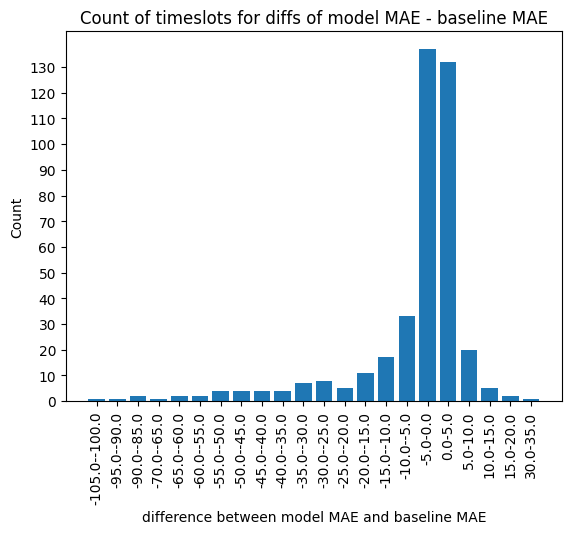

In [125]:
def count_ranges(numbers, range_size):
    range_counts = {}
    for num in numbers:
        range_start = num // range_size * range_size
        range_end = range_start + range_size
        range_label = f"{range_start}-{range_end}"
        if range_label not in range_counts:
            range_counts[range_label] = 0
        range_counts[range_label] += 1
    return range_counts


range_counts = count_ranges(diffs, 5)
for label, count in range_counts.items():
    print(f"{label}: {count}")
labels = list(range_counts.keys())
values = list(range_counts.values())

# Creating the bar chart
plt.bar(labels, values)

# Adding a title and axis labels
plt.title("Count of timeslots for diffs of model MAE - baseline MAE")
plt.xlabel("difference between model MAE and baseline MAE")
plt.ylabel("Count")
plt.xticks(rotation=90)
maxValue = sorted(values)[len(values)-1]
plt.yticks([10*i for i in range(0, 1+(maxValue//10))])
# Displaying the chart
plt.show()

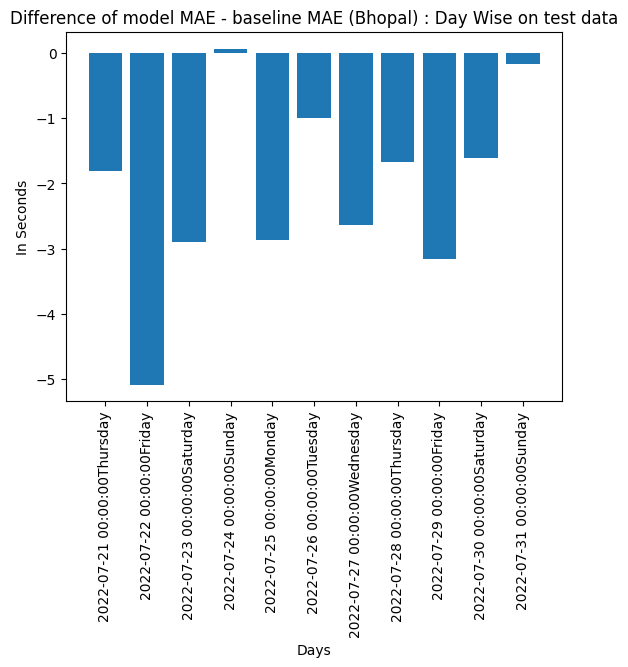

In [130]:
x = []
for day in allDays[len(allDays)-11:]:
    dd = getDayOfTheWeek(datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()+1)
    x.append(day + str(dd))
dayWiseDiffs = []
for day in allDays:
    df2 = overallDF.loc[overallDF['Order_Date'] == day]
    if(df2.size == 0):
        continue
    maeModel = getMAE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
    maeBaseline = getMAE(df2.prep_time.values.tolist(), df2.hour_wise_avg_kpt_of_the_day.values.tolist())
    dayWiseDiffs.append(maeModel-maeBaseline)
y = dayWiseDiffs[len(allDays)-11:]

# Creating the bar chart
plt.bar(x, y)

# Adding a title and axis labels
plt.title("Difference of model MAE - baseline MAE (Bhopal) : Day Wise on test data")
plt.xlabel("Days")
plt.ylabel("In Seconds")
plt.xticks(rotation=90)
# maxValue = sorted(values)[len(values)-1]
# plt.yticks([10*i for i in range(0, 1+(maxValue//10))])
# Displaying the chart
plt.show()

In [128]:
allDays

array(['2022-07-01 00:00:00', '2022-07-02 00:00:00',
       '2022-07-03 00:00:00', '2022-07-04 00:00:00',
       '2022-07-05 00:00:00', '2022-07-06 00:00:00',
       '2022-07-07 00:00:00', '2022-07-08 00:00:00',
       '2022-07-09 00:00:00', '2022-07-10 00:00:00',
       '2022-07-11 00:00:00', '2022-07-12 00:00:00',
       '2022-07-13 00:00:00', '2022-07-14 00:00:00',
       '2022-07-15 00:00:00', '2022-07-16 00:00:00',
       '2022-07-17 00:00:00', '2022-07-18 00:00:00',
       '2022-07-19 00:00:00', '2022-07-20 00:00:00',
       '2022-07-21 00:00:00', '2022-07-22 00:00:00',
       '2022-07-23 00:00:00', '2022-07-24 00:00:00',
       '2022-07-25 00:00:00', '2022-07-26 00:00:00',
       '2022-07-27 00:00:00', '2022-07-28 00:00:00',
       '2022-07-29 00:00:00', '2022-07-30 00:00:00',
       '2022-07-31 00:00:00'], dtype=object)

In [99]:
modelAE = []
baselineAE = []
for i in range(0, len(a)):
    modelAE.append(abs(a[i] - b[i]))
    baselineAE.append(abs(a[i] - c[i]))

In [100]:
diffs = [modelAE[i]-baselineAE[i] for i in range(0, len(a))]

In [105]:
diffs = sorted(diffs)

In [106]:
diffs[0], diffs[len(a)//2], diffs[len(a)-1]

(-271.5181277581554, -1.1254351391601745, 355.31615795163566)

In [83]:
dfError

,storeId,date,timeslot,weekday,model rmse,baseline rmse,model mae,baseline mae
0,DPI67072,2022-07-01 00:00:00,12.0,Friday,5.164115,17.314934,4.730251,13.095089
1,DPI67072,2022-07-01 00:00:00,13.0,Friday,121.113409,118.159915,78.814145,78.942169
2,DPI67072,2022-07-01 00:00:00,14.0,Friday,74.466449,85.333672,64.413952,74.934043
3,DPI67072,2022-07-01 00:00:00,15.0,Friday,18.957384,22.592124,13.970204,15.314531
4,DPI67072,2022-07-01 00:00:00,16.0,Friday,52.131350,43.986932,45.474937,36.232924
...,...,...,...,...,...,...,...,...
4746,DPI63827,2022-07-31 00:00:00,20.0,Sunday,53.290931,49.471267,41.232851,42.672444
4747,DPI63827,2022-07-31 00:00:00,21.0,Sunday,59.529704,61.558231,48.476673,49.336922
4748,DPI63827,2022-07-31 00:00:00,22.0,Sunday,84.876019,86.063441,69.797035,75.205524
4749,DPI63827,2022-07-31 00:00:00,23.0,Sunday,67.340737,69.117725,61.959122,63.184421


In [95]:
allTimeslots = sorted(overallDF.feature_3.unique())

In [96]:
allTimeslots

[1.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0]

In [212]:
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
#     for day in allDays:
    for ts in allTimeslots:
        day = allDays[26]
        df2 = df.loc[(df['Order_Date'] == day) & (df['feature_3'] == ts)]
        if(df2.size == 0):
            continue
        rmseModel = getRMSE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
        rmseBaseline = getRMSE(df2.prep_time.values.tolist(), df2.avg_kpt_in_last_one_hour.values.tolist())
        weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
        print(f"Day : {day}, Week: {weekday}, timeslot: {ts}, Model RMSE: {rmseModel}, Baseline RMSE : {rmseBaseline}")    

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 12.0, Model RMSE: 38.71929537172789, Baseline RMSE : 33.56447185074673
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 13.0, Model RMSE: 45.02856316840642, Baseline RMSE : 47.21386577939607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 14.0, Model RMSE: 59.40477608850966, Baseline RMSE : 73.11086865665474
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 15.0, Model RMSE: 67.88246709951804, Baseline RMSE : 66.9939476028299
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 33.07842101902586, Baseline RMSE : 46.350228538940065
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 196.30736784236922, Baseline RMSE : 203.7129211528454
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 93.05375601228607, Baseline RMSE : 92.31384320295317
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 102.61300312308741, Baseline RMSE : 92.63588547227084
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 249.01770994611056, Baseline RMSE : 235.09958136841604
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 169.8044944230333, Baseline RMSE : 221.08366040769852
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 120.08443320087714, Baseline RMSE : 150.0856642030031
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 22.822809251239256, Baseline RMSE : 24.73499697724607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE: 55.043140899304476, Baseline RMSE : 62.20706625481537
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 21.0, Model RMSE: 20.277607114360446, Baseline RMSE : 27.394911756924294
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 22.0, Model RMSE: 16.93295838133628, Baseline RMSE : 21.347949549528956
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 23.0, Model RMSE: 40.65216801827357, Baseline RMSE : 29.173474445387626
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 24.0, Mo

In [198]:
a = Counter(overallDF.prep_time.values.tolist())
a = {}
for day in allDays:
    d = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
    avgPrepTime = mean(overallDF.loc[overallDF['feature_2'] == d+1].prep_time.values.tolist())
    a[d+1] = avgPrepTime

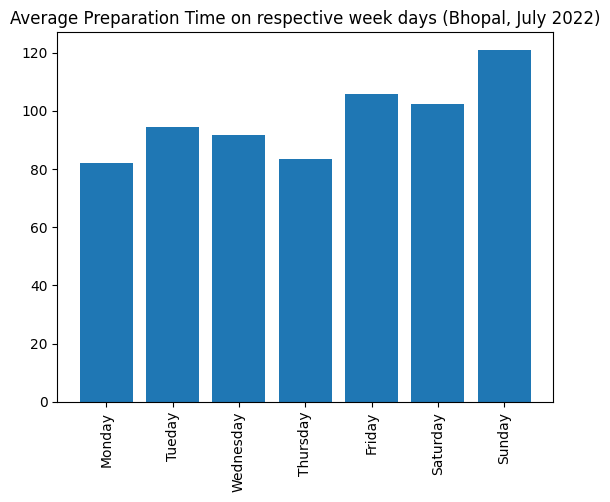

In [200]:
from matplotlib import pyplot
x = ['Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [a[1], a[2], a[3], a[4], a[5], a[6], a[7]]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective week days (Bhopal, July 2022)")
pyplot.show()

In [202]:
a = {}
for ts in allTimeslots:
    print(ts)
    avgPrepTime = mean(overallDF.loc[overallDF['feature_3'] == ts].prep_time.values.tolist())
    a[ts] = avgPrepTime

1.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


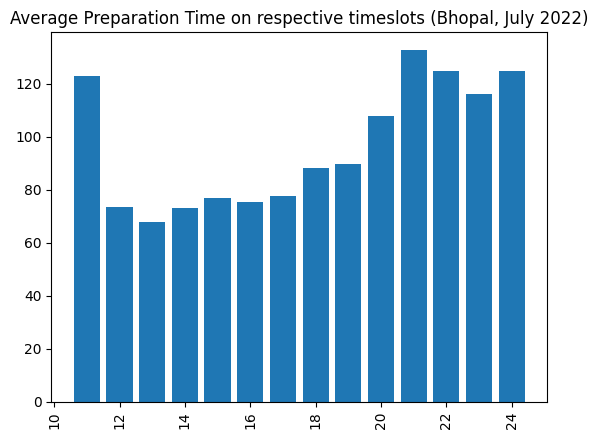

In [205]:
from matplotlib import pyplot
x = [i for i in range(11, 25)]
y = [a[i] for i in range(11, 25)]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective timeslots (Bhopal, July 2022)")
pyplot.show()

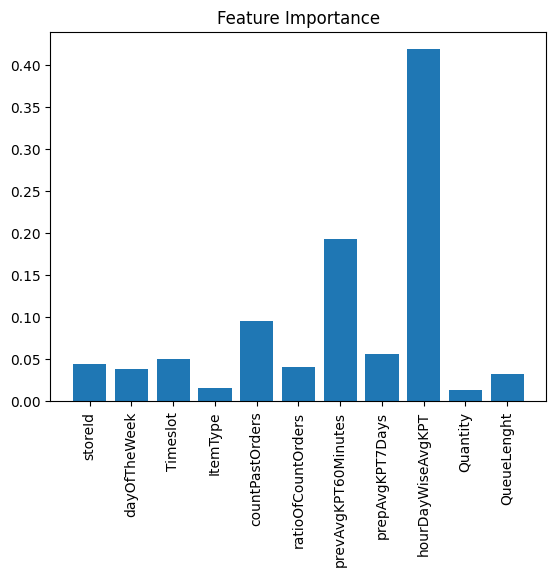

0.9999999087303877


In [226]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [ ]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

In [ ]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

In [ ]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist', 'auto'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)